In [8]:
import os

ROOT_DIR = '/content/'
DATA_ROOT = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT, 'Testing')

In [9]:
import shutil
import os
try:
    DATASET_PATH = '/content/drive/MyDrive/Git/ICT_Visual/Data'

    shutil.copy(os.path.join(DATASET_PATH,'brain_tumor.zip'),ROOT_DIR)
except Exception as err:
    print(str(err))

In [10]:
if os.path.exists(DATA_ROOT):
    shutil.rmtree(DATA_ROOT)
    print(f'{DATA_ROOT} is removed !')

In [11]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR,'brain_tumor.zip')) as target_file:
    target_file.extractall(DATA_ROOT)

In [12]:
# move test data to train directory

train_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)
test_label_list = os.listdir(TEST_DATA_ROOT_DIR)

# 전체 데이터 개수 확인

In [13]:
#================================================
# train 정답 및 전체 데이터 개수
#================================================

for label_name in train_label_list:

    print(f'train label {label_name} => {len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR,label_name)))}')

print('================================================================')

#================================================
# test 정답 및 전체 데이터 개수
#================================================

for label_name in test_label_list:

    print(f'test label {label_name} => {len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR,label_name)))}')

print('================================================================')


train label glioma_tumor => 826
train label meningioma_tumor => 822
train label pituitary_tumor => 827
train label no_tumor => 395
test label glioma_tumor => 100
test label meningioma_tumor => 115
test label pituitary_tumor => 74
test label no_tumor => 105


# Label 개수 확인

In [14]:
train_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)
test_label_list = os.listdir(TEST_DATA_ROOT_DIR)

print('num of train class : ', len(train_label_list))
print('num of test class : ', len(test_label_list))

num of train class :  4
num of test class :  4


# 이미지 사이즈 정의

In [15]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Image Data Generator 정의

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

In [17]:
train_data = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                               batch_size=32,
                                               color_mode='rgb',
                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                               class_mode='sparse')
test_data = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                               batch_size=32,
                                               color_mode='rgb',
                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                               class_mode='sparse')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


# label 확인

In [18]:
print(train_data.class_indices)
print(test_data.num_classes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


# 모델링

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, VGG16

In [20]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
mobilenet.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [21]:
class_nums = train_data.num_classes  # 정답개수

model_mobilenet = Sequential()

model_mobilenet.add(mobilenet)

model_mobilenet.add(GlobalAveragePooling2D())

model_mobilenet.add(Dense(512, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(128, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(class_nums, activation='softmax'))

model_mobilenet.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(2e-5),
              metrics=['acc'])

model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

# Training

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime


earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist_mobilenet = model_mobilenet.fit(train_data,
                 epochs=30,
                 validation_data=test_data)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/30
90/90 [==============================] - 50s 358ms/step - loss: 1.6140 - acc: 0.3676 - val_loss: 1.2500 - val_acc: 0.3883
Epoch 2/30
90/90 [==============================] - 30s 335ms/step - loss: 0.9837 - acc: 0.5913 - val_loss: 1.1696 - val_acc: 0.4797
Epoch 3/30
90/90 [==============================] - 31s 343ms/step - loss: 0.7386 - acc: 0.7192 - val_loss: 1.1544 - val_acc: 0.4873
Epoch 4/30
90/90 [==============================] - 30s 335ms/step - loss: 0.6012 - acc: 0.7596 - val_loss: 1.1110 - val_acc: 0.5406
Epoch 5/30
90/90 [==============================] - 30s 335ms/step - loss: 0.4697 - acc: 0.8307 - val_loss: 1.1042 - val_acc: 0.5736
Epoch 6/30
90/90 [==============================] - 30s 335ms/step - loss: 0.4263 - acc: 0.8551 - val_loss: 1.0808 - val_acc: 0.5990
Epoch 7/30
90/90 [==============================] - 30s 334ms/step - loss: 0.3791 - acc: 0.8617 - val_loss: 1.0075 - val_acc: 0.6675
Epoch 8/30
90/90 [==============================] - 30s 336ms/step - 

In [23]:
model_mobilenet.evaluate(test_data)

13/13 [==============================] - 2s 141ms/step - loss: 1.4559 - acc: 0.7716


[1.4558753967285156, 0.7715736031532288]

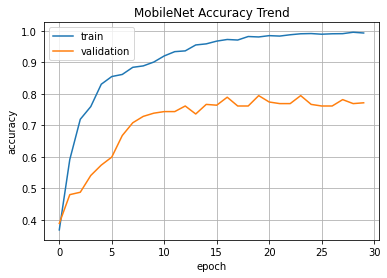

In [24]:
import matplotlib.pyplot as plt

plt.plot(hist_mobilenet.history['acc'], label='train')
plt.plot(hist_mobilenet.history['val_acc'], label='validation')
plt.title('MobileNet Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

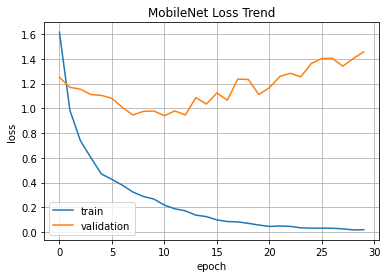

In [25]:
plt.plot(hist_mobilenet.history['loss'], label='train')
plt.plot(hist_mobilenet.history['val_loss'], label='validation')
plt.title('MobileNet Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()